In [22]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping,ModelCheckpoint
from scipy import signal
import os 
import pandas as pd

In [ ]:
import wandb
wandb.login()

## Data Loading

In [13]:
x_train=np.load('../BraiNeoCare_New/Datasets/balanced_x_train_common_4s.npy', mmap_mode='r')[0:10000,...]
x_test=np.load('../BraiNeoCare_New/Datasets/balanced_x_test_common_4s.npy', mmap_mode='r')
y_train=np.load('../BraiNeoCare_New/Datasets/balanced_y_train_common_4s.npy', mmap_mode='r')[0:10000,...]
y_test=np.load('../BraiNeoCare_New/Datasets/balanced_y_test_common_4s.npy', mmap_mode='r')

In [3]:
sos=signal.butter(10,[0.5,100],btype='bandpass',fs=256,output='sos')    

In [4]:
x_train=signal.sosfilt(sos,x_train,axis=1)
x_test=signal.sosfilt(sos,x_test,axis=1)

In [14]:
mean=x_train.mean()
std=x_train.std()
x_train=(x_train-mean)/std
x_test=(x_test-mean)/std

In [15]:
#shuffle the data
np.random.seed(42)
train_indices = np.arange(x_train.shape[0])
np.random.shuffle(train_indices)
x_train = x_train[train_indices].reshape(x_train.shape[0],1024,12)
y_train = y_train[train_indices]
test_indices = np.arange(x_test.shape[0])   
np.random.shuffle(test_indices)
x_test = x_test[test_indices].reshape(x_test.shape[0],1024,12)
y_test = y_test[test_indices]

In [ ]:
# x_train=x_train*(10**5)
# x_test=x_test*(10**5)

## Tiny model

In [16]:
'''For 4s partitions I used dropout=0.2, and learning rate=0.002, and weight decay=0.00015. Saved model is model1_for_4s.keras was taken
after 300 epoch with batch size=128'''

'''For 1s partitions I used dropout=0.2, and used Lr 0.005 and weigt decay 0.015. Saved model is model1_for_1s.keras was taken
after 125 epoch with batch size=256'''

Input=keras.Input(shape=(1024,12),name="Input_signal")
x=layers.Conv1D(32,3,padding="same",activation='swish')(Input)
y=layers.Conv1D(32,5,padding='same',activation='swish')(Input)
a=layers.add([x,y])
x=layers.MaxPooling1D(4)(a)
x=layers.SpatialDropout1D(0.2)(x)    
x=layers.Conv1D(64,3,padding="same",activation='swish')(x)
x=layers.GlobalAveragePooling1D()(x)
x=layers.Dense(32,activation='swish')(x) #comment this for 4s partitions
x=layers.Dense(16,activation='swish')(x)
x=layers.Dropout(0.2)(x)  
x=layers.Dense(1,activation='sigmoid')(x)

model1=keras.Model(inputs=Input,outputs=x)

optimizer=keras.optimizers.Adam(learning_rate=0.002,weight_decay=0.00015) 
 


F1 = keras.metrics.FBetaScore()
AUROC = keras.metrics.AUC(curve='ROC', name = 'AUROC')
AUPRC = keras.metrics.AUC(curve='PR', name = 'AUPRC')
model1.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy', F1, AUROC, AUPRC])

In [8]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_signal (InputLayer)   [(None, 1024, 12)]           0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1024, 32)             1184      ['Input_signal[0][0]']        
                                                                                                  
 conv1d_1 (Conv1D)           (None, 1024, 32)             1952      ['Input_signal[0][0]']        
                                                                                                  
 add (Add)                   (None, 1024, 32)             0         ['conv1d[0][0]',              
                                                                     'conv1d_1[0][0]']        

In [10]:
checkpoint_path='Saved_model_weights_1/cp_{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

In [17]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max')
cp_callback = ModelCheckpoint(filepath=checkpoint_path,monitor="val_loss",save_weights_only=False,verbose=1,save_best_only=True)

history=model1.fit(x_train,y_train,epochs=300,batch_size=128,validation_data=(x_test,y_test))

Epoch 1/300
79/79 [==============================] - 5s 31ms/step - loss: 0.6385 - accuracy: 0.6309 - fbeta_score: 0.7455 - AUROC: 0.6475 - AUPRC: 0.7393 - val_loss: 0.6083 - val_accuracy: 0.6502 - val_fbeta_score: 0.6667 - val_AUROC: 0.7481 - val_AUPRC: 0.7606
Epoch 2/300
79/79 [==============================] - 2s 20ms/step - loss: 0.5840 - accuracy: 0.6848 - fbeta_score: 0.7455 - AUROC: 0.7443 - AUPRC: 0.8131 - val_loss: 0.6336 - val_accuracy: 0.6332 - val_fbeta_score: 0.6667 - val_AUROC: 0.7638 - val_AUPRC: 0.7686
Epoch 3/300
79/79 [==============================] - 2s 20ms/step - loss: 0.5753 - accuracy: 0.6946 - fbeta_score: 0.7455 - AUROC: 0.7573 - AUPRC: 0.8231 - val_loss: 0.5827 - val_accuracy: 0.6708 - val_fbeta_score: 0.6667 - val_AUROC: 0.7788 - val_AUPRC: 0.7899
Epoch 4/300
79/79 [==============================] - 2s 20ms/step - loss: 0.5527 - accuracy: 0.7041 - fbeta_score: 0.7455 - AUROC: 0.7747 - AUPRC: 0.8375 - val_loss: 0.5973 - val_accuracy: 0.6658 - val_fbeta_score:

In [20]:
model1.save('best_model_for_4s_1.h5')

/home/nima/miniconda3/envs/BrainNeoCare/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
with open("history_for_4s_best_1.jason", 'w') as f:
    pd.DataFrame(history.history).to_json(f)

In [ ]:
# Plot the training and validation loss and accuracy for each epoch for 1s partitions

training_accuracy = history.history['accuracy']
val_accuracy=history.history['val_accuracy']
training_loss = history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
# plt.figure(figsize=(20, 10))
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
# plt.hlines(0.9)
plt.grid()
# plt.ylim(0,1)
# plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

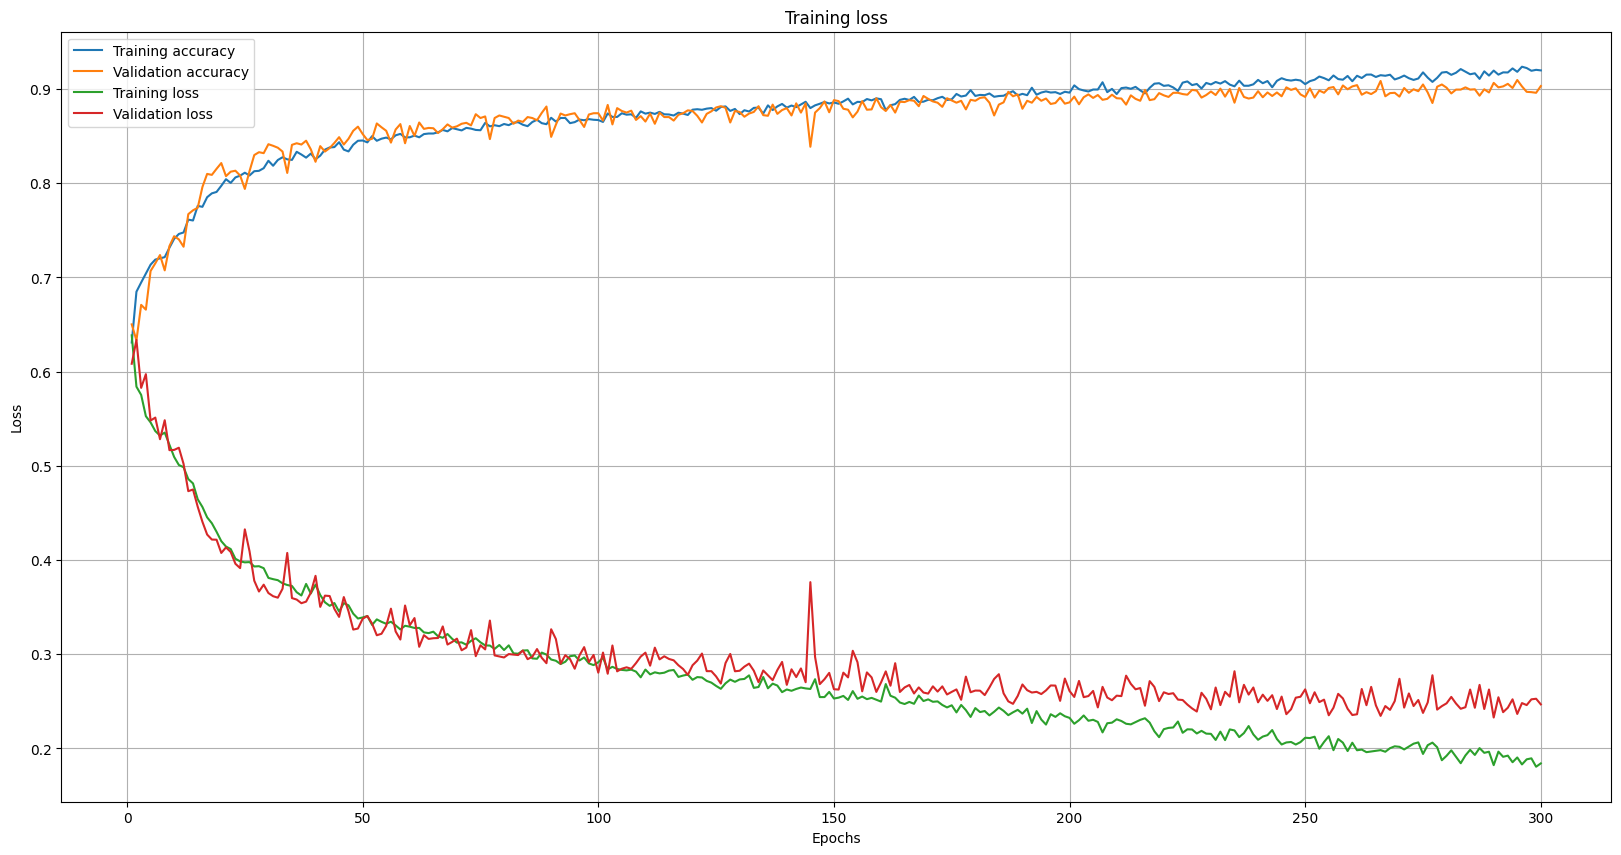

In [18]:
# Plot the training and validation loss and accuracy for each epoch for 4s partitions

training_accuracy = history.history['accuracy']
val_accuracy=history.history['val_accuracy']
training_loss = history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
plt.figure(figsize=(20, 10))
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.grid()
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Working large model

In [ ]:
def block_type1(n_filters1,n_filters2, kernel, pad, x):
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(x)
    block1=layers.BatchNormalization()(block1)
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block1)
    block1=layers.SpatialDropout1D(0.2)(block1)
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block1)
    block1=layers.BatchNormalization()(block1)
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block1)
    block1=layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(block1)
    block1=layers.BatchNormalization()(block1)

    block1_o=layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(x)
    block1_o=layers.BatchNormalization()(block1_o)
    added1=layers.add([block1,block1_o])
    return layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(added1)

def block_type2(n_filters1,n_filters2, kernel, pad, x):
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(x)
    block=layers.BatchNormalization()(block)
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block)
    block=layers.SpatialDropout1D(0.2)(block)
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block)
    block=layers.BatchNormalization()(block)
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block)
    block=layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(block)
    block=layers.BatchNormalization()(block)

    added=layers.add([x,block])
    return layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(added)

In [ ]:
def create_model():
  Input=keras.Input(shape=(256,12),name="Input_signal")
  x=layers.Conv1D(32,3,padding="same",activation='swish')(Input)
  y=layers.Conv1D(32,5,padding='same',activation='swish')(Input)
  a=layers.add([x,y])
  # x=layers.AveragePooling1D(2)(a)
  a=layers.SpatialDropout1D(0.2)(a) # was not here before
  x=layers.MaxPooling1D(4)(a)

  x1=block_type1(32,128,3,"same",x)
  x1=layers.SpatialDropout1D(0.2)(x1) 
  x2=block_type2(32,128,13,"same",x1)
  x2=layers.SpatialDropout1D(0.2)(x2)
  x3=block_type2(32,128,23,"same",x2)
  x3=layers.AveragePooling1D(4)(x3)
  x4=block_type1(64,256,7,"same",x3)
  x4=layers.SpatialDropout1D(0.2)(x4)
  x5=block_type2(64,256,17,"same",x4)
  x5=layers.SpatialDropout1D(0.2)(x5)
  x6=block_type2(64,256,27,"same",x5)
  x6=layers.SpatialDropout1D(0.2)(x6)
  x7=block_type2(64,256,7,"same",x6)
  x16=layers.GlobalAveragePooling1D()(x6)
  x16=layers.Dense(128)(x16) #previous 256
  x16=layers.Dropout(0.2)(x16) #previous 0.5
  x16=layers.Dense(16,activation='swish')(x16)
  x16=layers.Dense(1,activation='sigmoid')(x16)

  model=keras.Model(Input,x16)
  
  F1 = keras.metrics.FBetaScore()
  AUROC = keras.metrics.AUC(curve='ROC', name = 'AUROC')
  AUPRC = keras.metrics.AUC(curve='PR', name = 'AUPRC')

  # used the followiing one to get 0.99 accuracy for 4s data
  # model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', F1, AUROC, AUPRC])

  optimizer=keras.optimizers.Adam(learning_rate=0.001,weight_decay=0.0002)
  loss=keras.losses.BinaryCrossentropy(from_logits=False)
  model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy', F1, AUROC, AUPRC])
  
  # keras.utils.plot_model(model,'model.png',show_layer_activations=True,show_shapes=True)
  model.summary()
  return model

model = create_model()


In [ ]:
# used 128 as the batch size for 4s data
history=model.fit(x_train,y_train, validation_data = (x_test,y_test), epochs=100,batch_size=128)

In [ ]:
model.save('../BraiNeoCare/models/model1.h5')   

In [ ]:
training_accuracy = history.history['accuracy']
val_accuracy=history.history['val_accuracy']
training_loss = history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
# plt.figure(figsize=(6, 6))
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Nima's ECG model

In [ ]:
def create_model():
    i = keras.Input((1024,12), name='signal')
    x = layers.Conv1D(filters=72, kernel_size=15, activation='swish', padding='same')(i)
    a = layers.Conv1D(filters=72, kernel_size=1, padding='same')(i)
    a = layers.Add()([a,x])
    a = layers.Activation('swish')(a)
    x = layers.SpatialDropout1D(0.2)(a)
    b = layers.AveragePooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=144, kernel_size=3, activation='swish', padding='same')(b)
    a = layers.Conv1D(filters=144, kernel_size=1, padding='same')(b)
    a = layers.Add()([a,x])
    a = layers.Activation('swish')(a)
    x = layers.SpatialDropout1D(0.2)(a)
    b = layers.AveragePooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=288, kernel_size=5, activation='swish', padding='same')(b)
    a = layers.Conv1D(filters=288, kernel_size=1, padding='same')(b)
    a = layers.Add()([a,x])
    a = layers.Activation('swish')(a)
    x = layers.SpatialDropout1D(0.2)(a)
    b = layers.AveragePooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=576, kernel_size=7, activation='swish', padding='same')(b)
    a = layers.Conv1D(filters=576, kernel_size=1, padding='same')(b)
    a = layers.Add()([a,x])
    a = layers.Activation('swish')(a)
    b = layers.SpatialDropout1D(0.2)(a)
    x = layers.GlobalAveragePooling1D()(b)

    # j = keras.Input((2000,2*2), name='fft')
    # y = layers.Conv1D(filters=72, kernel_size=3, activation='swish', padding='same')(j)
    # y = layers.SpatialDropout1D(0.1)(y)
    # y = layers.AveragePooling1D(pool_size=2)(y)
    # y = layers.Conv1D(filters=144, kernel_size=5, activation='swish', padding='same')(y)
    # y = layers.SpatialDropout1D(0.1)(y)
    # y = layers.AveragePooling1D(pool_size=2)(y)
    # y = layers.Conv1D(filters=288, kernel_size=7, activation='swish', padding='same')(y)
    # y = layers.SpatialDropout1D(0.1)(y)
    # y = layers.AveragePooling1D(pool_size=2)(y)
    # y = layers.Conv1D(filters=576, kernel_size=9, activation='swish', padding='same')(y)
    # y = layers.SpatialDropout1D(0.1)(y)
    # y = layers.AveragePooling1D(pool_size=2)(y)
    # y = layers.Conv1D(filters=1152, kernel_size=11, activation='swish', padding='same')(y)
    # y = layers.SpatialDropout1D(0.1)(y)
    # y = layers.GlobalAveragePooling1D()(y)

    # f = layers.Concatenate()([x,y])
    # f = layers.Activation('swish')(f)

    f = layers.Dense(576, activation='swish')(x)
    f = layers.Dropout(0.5)(f)
    f = layers.Dense(1,activation = 'sigmoid')(f)

    F1 = tfa.metrics.FBetaScore(num_classes=1)
    AUROC = tf.keras.metrics.AUC(curve='ROC', name = 'AUROC')
    AUPRC = tf.keras.metrics.AUC(curve='PR', name = 'AUPRC')
    model = keras.Model(i,f)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', AUROC, AUPRC])
    tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,layer_range=None, show_layer_activations=False)
    return model

with tpu_strategy.scope():
  model = create_model()


In [ ]:
tf.keras.utils.plot_model(model,'/content/drive/MyDrive/FYP_ML/model_nima.png')

In [ ]:
weight_for_0 = (1 / (tot-pos)) * (tot / 2.0)
weight_for_1 = (1 / pos) * (tot / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(train_dataset, validation_data = test_dataset, epochs=100)

## Small model

In [ ]:

# import tensorflow_addons as tfa
# from sklearn.model_selection import train_test_split

model=keras.Sequential(name="BrainNeoCare_CNN")
model.add(keras.layers.Conv2D(filters=32, kernel_size=(1,3), activation='relu', input_shape=(12,1024),name="Input_conv2D"))
model.add(keras.layers.MaxPooling2D((1,2),name="Maxpooling2D_1"))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(1,3), activation='relu',name="Conv2D_2"))
model.add(keras.layers.MaxPooling2D((1,2),name="Maxpooling2D_2"))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(1,3), activation='relu',name="Conv2D_3"))
model.add(keras.layers.MaxPooling2D((1,2),name="Maxpooling2D_3"))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(1,3), activation='relu',name="Conv2D_4"))
model.add(keras.layers.AveragePooling2D((1,2),name="AveragePooling2D_1"))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu',name="2D_F_Con"))
model.add(keras.layers.AveragePooling2D((1,2),name="AveragePooling2D_2"))
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu',name="2D_F_Con_2"))
model.add(keras.layers.MaxPooling2D((1,2),name="AveragePooling2D_3"))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu') )
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
loss=tf.keras.losses.BinaryCrossentropy(from_logits=False, name="binary_crossentropy",)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(train_dataset,epochs=10,verbose=1)

## Data manipulation and loading

In [ ]:
x=np.load('/content/drive/MyDrive/FYP_ML/zenodo_data.npy', mmap_mode='r')
y=np.load('/content/drive/MyDrive/FYP_ML/zenodo_labels.npy', mmap_mode='r')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)